# Property Value Estimation using 5% Sample
This notebook prepares a 5% sample from the full NYC property dataset, performs cleaning, encodes categorical variables, removes extreme property values, and prepares the dataset for modeling.

In [1]:
# Step 1: Mount Google Drive and load dataset
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
file_path = '/content/drive/My Drive/SMU_MITB_AML/Group Project/Property_Valuation_and_Assessment_Data.csv'
df = pd.read_csv(file_path)
print('Full dataset shape:', df.shape)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Full dataset shape: (9845857, 40)


,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,VALTYPE,Borough,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA,New Georeferenced Column
0,1000163859,1,16,3859,NaN,"CHEN, QI TOM",R4,2,0,0,...,AC-TR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000730028,1,73,28,NaN,NYC DSBS,V1,4,183,52,...,AC-TR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000730029,1,73,29,NaN,NYC DSBS,Y7,4,90,500,...,AC-TR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000297504,1,29,7504,NaN,NaN,R0,2,36,73,...,AC-TR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000360012,1,36,12,NaN,NYC DSBS,Y7,4,534,604,...,AC-TR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Step 2: Sample 5% of data and save
import numpy as np
np.random.seed(42)
fivepercent = df.sample(frac=0.05)
print('5% sample shape:', fivepercent.shape)
fivepercent_file_path = '/content/drive/My Drive/SMU_MITB_AML/Group Project/fivepercent.csv'
fivepercent.to_csv(fivepercent_file_path, index=False)
print(f"Saved to {fivepercent_file_path}")

5% sample shape: (492293, 40)
Saved to /content/drive/My Drive/SMU_MITB_AML/Group Project/fivepercent.csv


In [3]:
# Step 3: Load 5% data for cleaning
df = pd.read_csv('/content/drive/My Drive/SMU_MITB_AML/Group Project/fivepercent.csv')
print('Initial shape:', df.shape)

Initial shape: (492293, 40)


In [4]:
# Step 4: Drop columns with high missing values
columns_to_drop = ['EASEMENT', 'EXMPTCL', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2', 'EXCD2']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

In [5]:
# Step 5: Remove rows with extremely high FULLVAL (e.g., > 5e7)
df = df[df['FULLVAL'] < 5e7]
print('After removing extreme FULLVAL:', df.shape)

After removing extreme FULLVAL: (491546, 33)


In [6]:
# Step 6: Drop rows with missing values in required fields
required_cols = ['FULLVAL', 'BORO', 'BLOCK', 'LOT', 'TAXCLASS', 'LTFRONT', 'LTDEPTH',
                 'AVLAND', 'AVTOT', 'BLDFRONT', 'BLDDEPTH', 'EXLAND', 'EXTOT',
                 'OWNER', 'BLDGCL', 'POSTCODE', 'Borough']
df = df.dropna(subset=required_cols)
print('After dropping rows with missing required fields:', df.shape)

After dropping rows with missing required fields: (464384, 33)


In [7]:
# Step 7: Encode categorical variables using LabelEncoder
from sklearn.preprocessing import LabelEncoder
cat_cols = ['TAXCLASS', 'OWNER', 'BLDGCL', 'POSTCODE', 'Borough']
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
print('Encoding complete.')

Encoding complete.


In [8]:
# Step 8: Save cleaned 5% dataset
cleaned_path = '/content/drive/My Drive/SMU_MITB_AML/Group Project/fivepercent_cleaned.csv'
df.to_csv(cleaned_path, index=False)
print(f"Cleaned dataset saved to {cleaned_path}")

Cleaned dataset saved to /content/drive/My Drive/SMU_MITB_AML/Group Project/fivepercent_cleaned.csv


In [9]:
# Step 9: Load cleaned 5% dataset
df = pd.read_csv('/content/drive/My Drive/SMU_MITB_AML/Group Project/fivepercent_cleaned.csv')

/tmp/ipython-input-9-873522660.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/My Drive/SMU_MITB_AML/Group Project/fivepercent_cleaned.csv')


In [10]:
# Step 10: Prepare feature matrix X and target vector y
feature_cols = [
    'BORO', 'BLOCK', 'LOT', 'TAXCLASS', 'LTFRONT', 'LTDEPTH',
    'AVLAND', 'AVTOT', 'BLDFRONT', 'BLDDEPTH', 'EXLAND', 'EXTOT',
    'OWNER', 'BLDGCL', 'POSTCODE', 'Borough'
]
target_col = 'FULLVAL'
X = df[feature_cols].values
y = df[target_col].values

In [11]:
# Step 11: Split data and apply log1p transform to target
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

In [12]:
# Step 12: Standardize features using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Step 13: Build and compile the neural network model (with safer clip)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda
import tensorflow.keras.backend as K

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Lambda(lambda x: K.clip(x, 0, 16)))  # Clip log output to avoid overflow
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Step 14: Train the model with callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
9288/9288 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 6.3039 - mae: 1.1418 - val_loss: 0.4372 - val_mae: 0.3446 - learning_rate: 0.0010
Epoch 2/100
9288/9288 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.3422 - mae: 0.3132 - val_loss: 0.3142 - val_mae: 0.2747 - learning_rate: 0.0010
Epoch 3/100
9288/9288 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.2651 - mae: 0.2727 - val_loss: 0.2550 - val_mae: 0.2666 - learning_rate: 0.0010
Epoch 4/100
9288/9288 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.2119 - mae: 0.2439 - val_loss: 0.2089 - val_mae: 0.2053 - learning_rate: 0.0010
Epoch 5/100
9288/9288 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.1910 - mae: 0.2280 - val_loss: 0.2096 - val_mae: 0.2230 - learning_rate: 0.0010
Epoch 6/100
9288/9288 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.1698 - mae: 0.2152 - val_loss: 0.2140 - val_mae: 0.2148 - learning_rate: 0.0010
Epoch 7/100
9288/9288 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.1635 - mae: 0.2109 - val_loss: 0.2070 - val_mae: 0.2104 - 

In [15]:
# Step 15: Predict, inverse log, and evaluate model performance
y_pred_log = model.predict(X_test_scaled).flatten()
y_pred_log = np.clip(y_pred_log, a_min=None, a_max=20)
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

2903/2903 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
MSE: 125217272063.65
MAE: 101276.52
R²: 0.9702


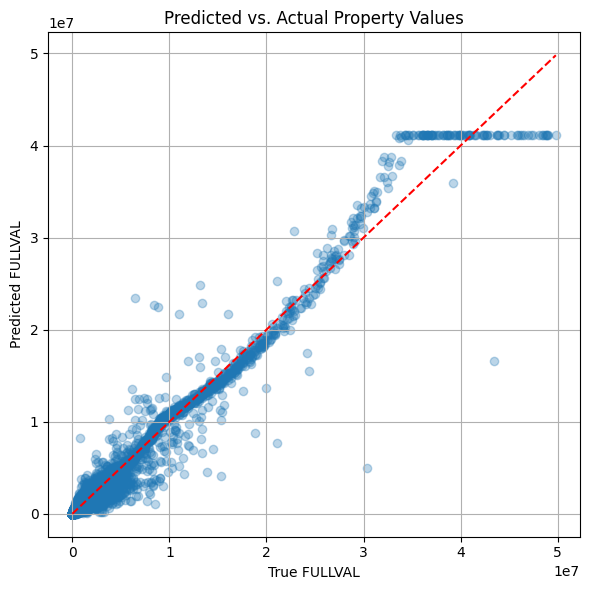

In [16]:
# Step 16: Visualize predictions vs actual values
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.scatter(y_test_actual, y_pred, alpha=0.3)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel("True FULLVAL")
plt.ylabel("Predicted FULLVAL")
plt.title("Predicted vs. Actual Property Values")
plt.grid(True)
plt.tight_layout()
plt.show()